# SIR Model

Sources:
- http://hplgit.github.io/prog4comp/doc/pub/._p4c-solarized-Python021.html
- http://hplgit.github.io/disease-modeling/doc/pub/disease_modeling-beamer-red_shadow.pdf

Parameteres:
- N = number of elemements in the population
- sim_days = number of days to run the simulation for
- orig_infected = number of individuals infected by the desease on the first day
- prob_infect = probability of being contaged if in contact with an infected person
- contact_with_people = number of people each element is in contact with during a day
- beta = average amount of people an infected element can be able to infect in a day
- days = number of days the desease lasts (how many days is someone contageous)
- S(t) = number of susceptible elements at time t
- I(t) = number of infected elements at time t
- R(t) = number of recovered elements at time t
- gamma = percentage of how many individuals recover from the desease each day
- R0 = total number of people an infected individual infects while being ill
- immu_days = how long the immunity from the desease lasts
- alpha = percentage of people dying if positive
- death_days = number of days from infection from death
- vacc_cap = vaccination capacity

In [71]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [101]:
def timed_sir_step_ahead(y, t, N, beta, gamma, v):
    S, I, R = y
    dsdt = -beta * I * (S / N) + v*R
    didt = beta * I * (S / N) - gamma * I
    drdt = gamma * I - v*R
    return dsdt, didt, drdt

def timed_SIR_sim(N, sim_days, orig_infected, prob_infect, contact_with_people, days, immu_days):
    y0 = N-orig_infected, orig_infected, 0
    beta = prob_infect*contact_with_people
    gamma = 1.0 / days
    v = 1.0/immu_days
    R0 = beta/gamma
    t = np.linspace(0, sim_days-1, sim_days)
    sim_res = odeint(timed_sir_step_ahead, y0, t, args=(N, beta, gamma, v))
    S, I, R = sim_res.T
    return S, I, R, R0

N = 1000
sim_days = 100
orig_infected = 3
prob_infect = 0.05
contact_with_people = 10
days = 5
immu_days = 10

S, I, R, R0 = timed_SIR_sim(N, sim_days, orig_infected, prob_infect, contact_with_people, days, immu_days)

In [102]:
def timed_SIR_plot(negatives, positives, survivors, R0):
    fig = go.Figure(
        data=[go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
                         mode="lines", name='Susceptible',
                         line=dict(width=2, color="blue")),
              go.Scatter(x=[i for i in range(len(negatives))], y=positives,
                         mode="lines", name='Infected',
                         line=dict(width=2, color="green")),
             go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
                         mode="lines", name='Recovered',
                         line=dict(width=2, color="orange"))],
            layout=go.Layout(
            title_text="Time Limited Immunity SIR Model (R<sub>0</sub>="+ str(round(R0, 2))+')', hovermode="closest",
            updatemenus= [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 100, "redraw": False},
                                            "fromcurrent": True, 
                                            "transition": {"duration": 10,
                                                           "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.14,
                    "xanchor": "right",
                    "y": 1.65,
                    "yanchor": "top"
                }
            ]),

        frames=[go.Frame(
            data=[go.Scatter(
                x=[i for i in range(k)],
                y=negatives,
                mode="lines",
                line=dict(width=2, color="blue")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=positives,
                mode="lines",
                line=dict(width=2, color="green")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=survivors,
                mode="lines",
                line=dict(width=2, color="orange"))])

            for k in range(len(negatives))],

    )
    fig.update_xaxes(title_text="Number of Days")
    fig.update_yaxes(title_text="Number of Cases")
    fig.show()

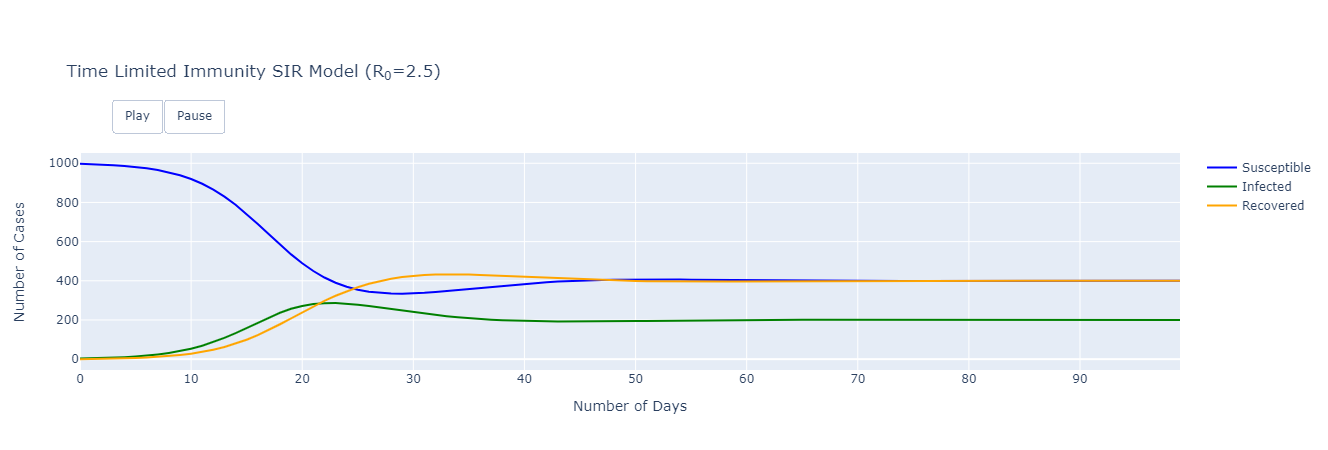

In [103]:
timed_SIR_plot(S, I, R, R0)

In [104]:
def vacc_start(t, start, p, S):
    if t >= start:
        res = p*S
    else:
        res = 0
    return res

def vacc_sir_step_ahead(y, t, N, beta, gamma, v, start_date, p, alpha, rho):
    S, V, I, R, D = y
    vacc = vacc_start(t, start_date, p, S)
    dsdt = -beta * I * (S / N) + v*R - vacc
    dvdt = vacc
    didt = beta * I * (S / N) -(1-alpha)*gamma*I -alpha*rho*I
    drdt = (1-alpha)*gamma*I - v*R
    dddt = alpha * rho * I
    return dsdt, dvdt, didt, drdt, dddt

def vacc_SIR_sim(N, sim_days, orig_infected, prob_infect, contact_with_people, days, immu_days, start_date, p, alpha, death_days):
    y0 = N-orig_infected, 0, orig_infected, 0, 0
    beta = prob_infect*contact_with_people
    gamma = 1.0 / days
    v = 1.0/immu_days
    rho = 1.0/death_days
    R0 = beta/gamma
    t = np.linspace(0, sim_days-1, sim_days)
    sim_res = odeint(vacc_sir_step_ahead, y0, t, args=(N, beta, gamma, v, start_date, p, alpha, rho))
    S, V, I, R, D = sim_res.T
    return S, V, I, R, D, R0

N = 1000
sim_days = 100
orig_infected = 3
prob_infect = 0.05
contact_with_people = 10
days = 5
immu_days = 10
start_vacc = 20
vacc_cap = 0.1
alpha = 0.2  # 10% death rate
death_days = 8

S, V, I, R, D, R0 = vacc_SIR_sim(N, sim_days, orig_infected, prob_infect, contact_with_people, days, immu_days, start_vacc, vacc_cap, alpha, death_days)

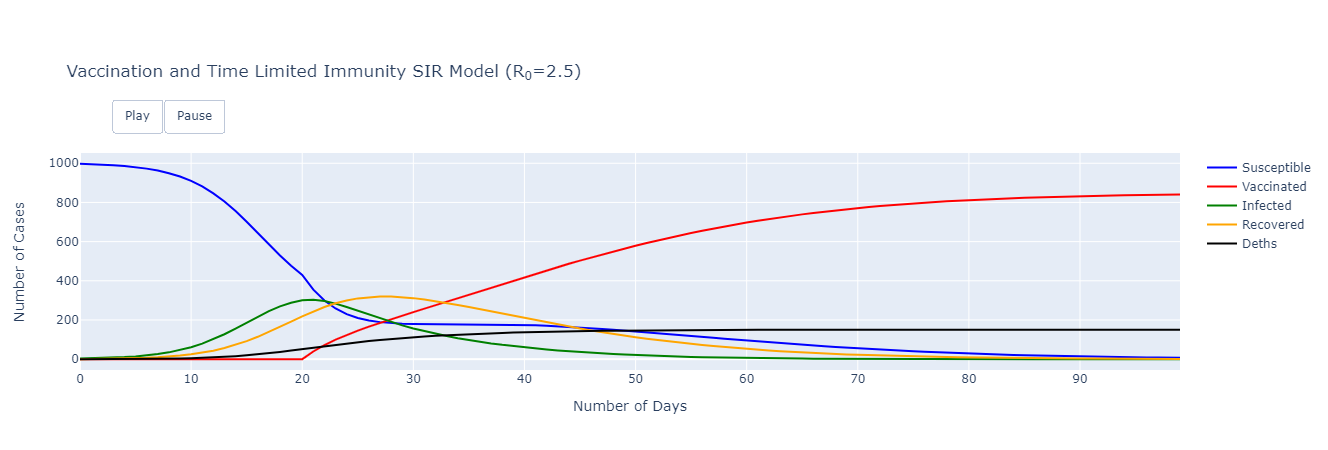

In [106]:
def vacc_SIR_plot(negatives, vaccinated, positives, survivors, deths, R0):
    fig = go.Figure(
        data=[go.Scatter(x=[i for i in range(len(negatives))], y=negatives,
                         mode="lines", name='Susceptible',
                         line=dict(width=2, color="blue")),
              go.Scatter(x=[i for i in range(len(negatives))], y=vaccinated,
                         mode="lines", name='Vaccinated',
                         line=dict(width=2, color="red")),
              go.Scatter(x=[i for i in range(len(negatives))], y=positives,
                         mode="lines", name='Infected',
                         line=dict(width=2, color="green")),
             go.Scatter(x=[i for i in range(len(negatives))], y=survivors,
                         mode="lines", name='Recovered',
                         line=dict(width=2, color="orange")),
             go.Scatter(x=[i for i in range(len(negatives))], y=deths,
                         mode="lines", name='Deths',
                         line=dict(width=2, color="black")),],
            layout=go.Layout(
            title_text="Vaccination and Time Limited Immunity SIR Model (R<sub>0</sub>="+ str(round(R0, 2))+')', hovermode="closest",
            updatemenus= [
                {
                    "buttons": [
                        {
                            "args": [None, {"frame": {"duration": 100, "redraw": False},
                                            "fromcurrent": True, 
                                            "transition": {"duration": 10,
                                                           "easing": "quadratic-in-out"}}],
                            "label": "Play",
                            "method": "animate"
                        },
                        {
                            "args": [[None], {"frame": {"duration": 0, "redraw": False},
                                              "mode": "immediate",
                                              "transition": {"duration": 0}}],
                            "label": "Pause",
                            "method": "animate"
                        }
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 87},
                    "showactive": False,
                    "type": "buttons",
                    "x": 0.14,
                    "xanchor": "right",
                    "y": 1.65,
                    "yanchor": "top"
                }
            ]),

        frames=[go.Frame(
            data=[go.Scatter(
                x=[i for i in range(k)],
                y=negatives,
                mode="lines",
                line=dict(width=2, color="blue")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=vaccinated,
                mode="lines",
                line=dict(width=2, color="red")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=positives,
                mode="lines",
                line=dict(width=2, color="green")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=survivors,
                mode="lines",
                line=dict(width=2, color="orange")),
                 go.Scatter(
                x=[i for i in range(k)],
                y=deths,
                mode="lines",
                line=dict(width=2, color="black"))])

            for k in range(len(negatives))],

    )
    fig.update_xaxes(title_text="Number of Days")
    fig.update_yaxes(title_text="Number of Cases")
    fig.show()
    
vacc_SIR_plot(S, V, I, R, D, R0)